# Trabajo Práctico 2 : Análisis de Sentimientos
**Grupo 22: JARVIS**

*   107666 CELANO MINIG, NICOLÁS FRANCO
*   108642 RANDO, JULIAN AGUSTIN
*   106421 GOMEZ, ALEJO


## Importes

Realizamos los importes necesarios para trabajar

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import math


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('words')


!pip install scattertext
!pip install -U spacy
!pip install unidecode
!pip install langdetect
!pip install fasttext
!pip install wget
!pip install wordcloud
!python -m spacy download es_core_news_sm

from wordcloud import WordCloud
import scattertext as st
from langdetect import detect
from IPython.display import display, HTML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words
from collections import Counter
from unidecode import unidecode
from matplotlib.ticker import ScalarFormatter
import fasttext
import wget
wget.download('https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin', 'lid.176.bin')
english_words = set(words.words())
model = fasttext.load_model('lid.176.bin')
nlp = spacy.load('es_core_news_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


2023-06-29 23:50:19.070880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


'lid.176 (1).bin'

## Funciones

### detect_lenguage

Recibe un texto, y utilizando detect de langdetect revuelve el idioma en el que se encuentra, y en caso de no saberlo retorna unknown

In [20]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

### remove_accents

Recibe un texto y devuelve el mismo sin acentos

In [21]:
def remove_accents(text):
    text_without_accents = unidecode(text)
    return text_without_accents

### is_english_word

Recibe una palabra y devuelve si está o no en ingles

In [22]:
def is_english_word(word):
    prediction = model.predict([word])
    if prediction[0][0] == '__label__en':
        return True
    else:
        return False

### is_valid_token

Recibe un token y devuelve si es o no válido

In [ ]:
def is_valid_token(token):
    return token.is_alpha and not token.is_stop and not token.ent_type_ and token.text.lower() not in english_words and not is_english_word(token.text.lower())

### separete_words

Recibe un texto, y si tiene una mayuscula en medio de la misma, separa en dos palabras diferentes

In [ ]:
def separate_words(text):
    pattern = r'([a-z]+)([A-Z][a-z]+)'
    separated_text = re.sub(pattern, r'\1 \2', text)

    return separated_text

### clean_tokenize_and_lamatize

Recibe un texto, realiza la limpieza del mismo y lo tokeiniza, lo valida y lo lematiza

In [ ]:
def clean_tokenize_and_lamatize(text):
    cleaned_text = re.sub(r'http\S+|www\S+|\S+@\S+', '', text)
    cleaned_text = ' '.join(re.findall(r'\w+', cleaned_text))
    cleaned_text = re.sub(r'_', lambda match: ' ', cleaned_text)
    cleaned_text = separate_words(cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    doc = nlp(cleaned_text)
    tokens = [remove_accents(token.lemma_.lower()) for token in doc if is_valid_token(token)]
    return tokens

## Set de datos a utilizar

Obtenemos los dataset de test y de train

In [23]:
partes_train = []
cant_partes = 3
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)
train_data = train_data.sort_values(by="ID").reset_index(drop=True).drop("ID", axis=1)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/test_tp2.csv"
test_data = pd.read_csv(test_url)
test_data_copy = test_data.copy()
test_data_copy= test_data_copy.drop("ID", axis=1)

####Visualizo las primeras filas de cada df para comenzar el analisis exploratorio

In [24]:
train_data.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [25]:
test_data.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


### Preprocesamiento de datasets

Primero observamos si existen casos nulos, como no los hay, continuamos

In [26]:
train_data.isnull().sum()

review_es      0
sentimiento    0
dtype: int64

Observamos que tenemos un set de datos balanceado perfectamente

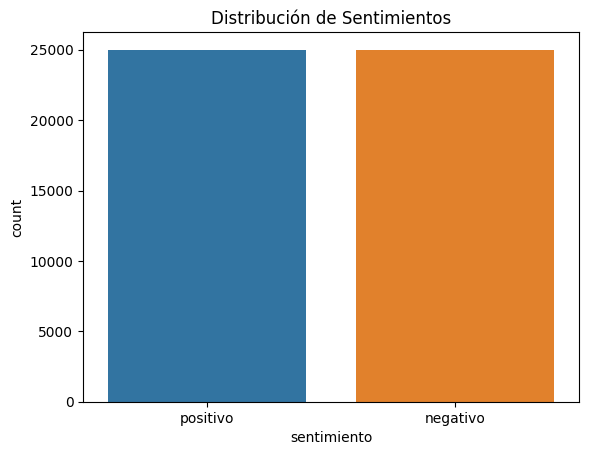


positivo    25000
negativo    25000
Name: sentimiento, dtype: int64


In [27]:
initial_size = train_data.shape[0]
sns.countplot(x='sentimiento', data=train_data)
plt.title('Distribución de Sentimientos')
plt.show()
print()
print(train_data['sentimiento'].value_counts())

Observemos si existen datos que se encuentre en un idioma que no sea el español

In [28]:
train_data['language'] = train_data['review_es'].apply(detect_language)

train_data = train_data[train_data['language'] == 'es']

Consideramos que estos son valores atípicos, ya que difieren significativamente del patrón general de los datos y pueden tener un impacto negativo en nuestro análisis. Por lo tanto, optamos por eliminarlos.

In [29]:
train_data = train_data.drop('language', axis=1)

Vemos que el set de datos sigue estando balanceado, aunque no de manera perfecta como antes. Además, observamos la cantidad de observaciones eliminadas

In [30]:
print(train_data['sentimiento'].value_counts())
print("Cantidad de datos eliminados:", (initial_size - train_data.shape[0]))

negativo    24133
positivo    24049
Name: sentimiento, dtype: int64
Cantidad de datos eliminados: 1818


Tokenizamos los datos en una nueva columna y eliminamos las palabras irrelevantes

In [35]:
train_data['tokens'] = train_data['review_es'].apply(clean_tokenize_and_lamatize)

In [36]:
test_data['tokens'] = test_data['review_es'].apply(clean_tokenize_and_lamatize)

Eliminamos los casos en donde los tokens de la review estan duplicados

In [39]:
cantidad_anterior = train_data.shape[0]
train_data = train_data[~train_data['tokens'].duplicated()]
print("Cantidad de casos duplicados eliminados: ", (cantidad_anterior - train_data.shape[0]))

Cantidad de casos duplicados eliminados:  404


Vamos a buscar outliers a traves de la longitud del token de cada reseña

In [40]:
train_data['token_length'] = train_data['tokens'].apply(lambda x: len(x))

<ipython-input-40-4118f4fd38dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['token_length'] = train_data['tokens'].apply(lambda x: len(x))


Veamos la distribución de la longitud de los tokens por sentimiento, para comprender mejor nuestros datos

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


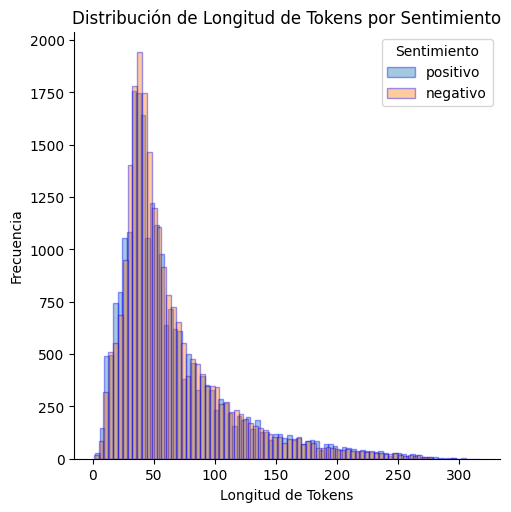

In [41]:
g = sns.FacetGrid(train_data, hue='sentimiento', height=5)

g.map(sns.distplot, 'token_length', bins=80, kde=False, hist_kws={"edgecolor":"blue"})

plt.legend(title='Sentimiento')
plt.xlabel('Longitud de Tokens')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de Tokens por Sentimiento')

plt.show()

Vamos a ver un boxplot para detectar los outliers

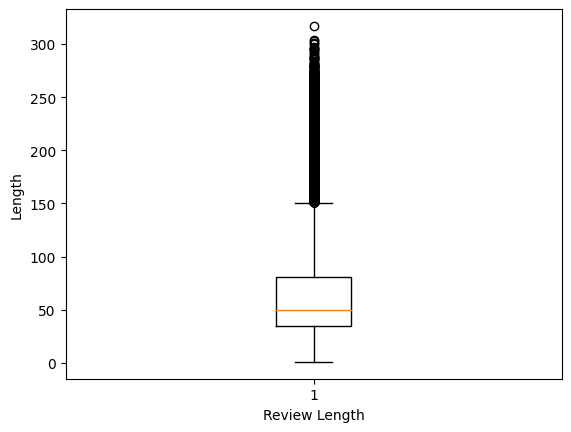

In [42]:
plt.boxplot(train_data['token_length'])
plt.xlabel('Review Length')
plt.ylabel('Length')

plt.show()

Podemos ver que a pesar de existir una cantidad importante de outliers superiores, ninguno se aleja mucho del resto, por lo que tomaremos a decisión de dejar tanto moderados como severos

In [43]:
Q1 = np.quantile(train_data['token_length'], 0.25)
Q3 = np.quantile(train_data['token_length'], 0.75)
IQR = Q3 - Q1
print("OUTLIERS")
print("Moderados inferiores: ",(train_data['token_length'] < (Q1 - 1.5*IQR)).sum())
print("Severos inferiores: ",(train_data['token_length'] < (Q3 - 3*IQR)).sum())
print("Moderados superiores: ",(train_data['token_length'] > (Q3 + 1.5*IQR)).sum())
print("Severos superiores: ",(train_data['token_length'] > (Q1 + 3*IQR)).sum())

OUTLIERS
Moderados inferiores:  0
Severos inferiores:  0
Moderados superiores:  3242
Severos superiores:  2053


Veamos con más detalle los outliers severos

In [44]:
train_sup =  train_data[train_data['token_length'] > (Q1 + 3*IQR)]
train_sup['sentimiento'].value_counts()

positivo    1133
negativo     920
Name: sentimiento, dtype: int64

Consideramos que son casos que se alejan de la media, por lo que procedemos a eliminarlos

In [45]:
train_data = train_data[train_data['token_length'] < (Q1 + 3*IQR)]

Eliminamos la columna de la longitud, ya que no se utilizará más

In [46]:
train_data = train_data.drop('token_length', axis=1)

Obtenemos una lista con todos los tokens, y calculamos la frecuencia de cada uno

In [47]:
all_tokens = [token for review_tokens in train_data['tokens'] for token in review_tokens]
token_frequencies = Counter(all_tokens)

Creamos un boxplot para ver la distribución de la frecuencia de las palabras en el conjunto de datos.



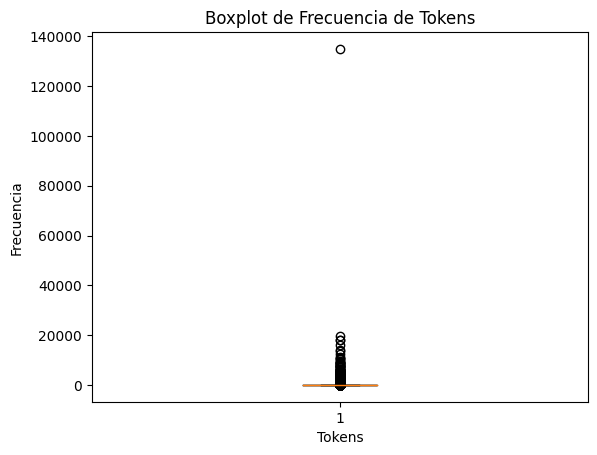

In [49]:
frequencies = list(token_frequencies.values())

plt.boxplot(frequencies)

plt.xlabel('Tokens')
plt.ylabel('Frecuencia')
plt.title('Boxplot de Frecuencia de Tokens')

plt.show()

Aqui se puede observar que tenemos una palabra con una frecuencia muy superior al resto

Lo podemos ver mejor en la siguiente nube de palabras

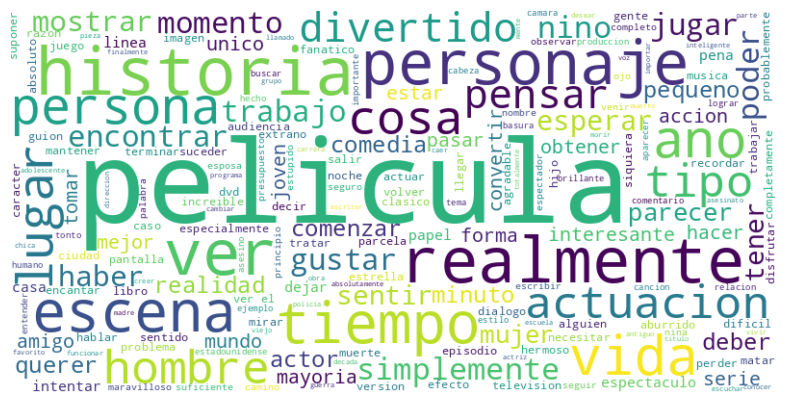

In [50]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Podemos apreciar que "pelicula" es la palabra que habiamos visualizado antes con una frecuencia muy superior

In [51]:
print("Cantidad total de tokens: ",len(all_tokens))
print("Cantidad de tokens diferentes:",len(token_frequencies))

Cantidad total de tokens:  2668079
Cantidad de tokens diferentes: 59229


Analizamos que porcentaje de tokens abarca "pelicula"

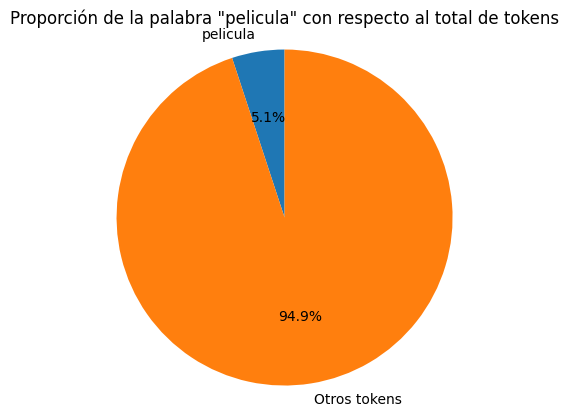

In [52]:
frecuencia_pelicula = token_frequencies.get("pelicula", 0)

frecuencia_otras_palabras = sum(token_frequencies.values()) - frecuencia_pelicula

sizes = [frecuencia_pelicula, frecuencia_otras_palabras]
labels = ["pelicula", "Otros tokens"]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

plt.axis('equal')
plt.title('Proporción de la palabra "pelicula" con respecto al total de tokens')
plt.show()

Decidimos eliminar la palabra pelicula pero antes de eso seguimos explorando los tokens en funcion de su frecuencia

Ordenamos los tokens y sus respectivas frecuencias, y observamos el siguiente gráfico que utilizaremos luego para calcular el umbral de corte tanto minimo como maximo.

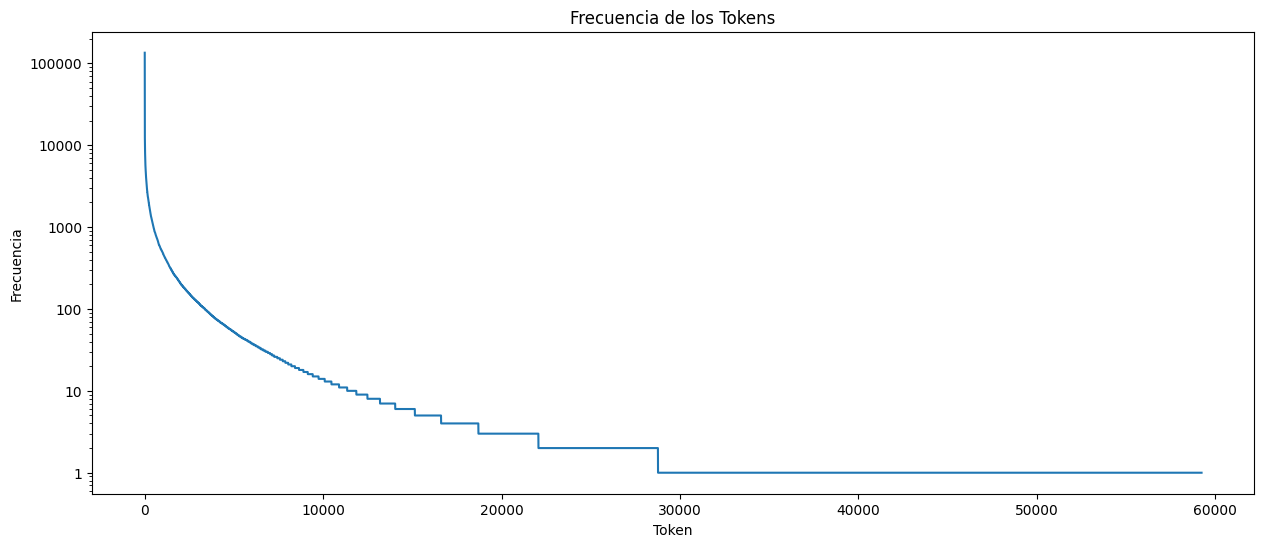

In [53]:
frequencies = token_frequencies.values()

sorted_frequencies = sorted(frequencies, reverse=True)

x = list(range(1, len(sorted_frequencies) + 1))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, sorted_frequencies, linestyle='-')
ax.set_yscale('log')

plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de los Tokens')

ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

Encontremos y veamos la cantidad de palabras frecuentes, estableciendo un umbral de 5

In [54]:
word_counts = Counter(word for tokens in train_data['tokens'] for word in tokens)
frequent_words = [word for word, count in word_counts.items() if count < 5]
print("Cantidad de tokens diferentes: ",len(word_counts))
print("Cantidad de tokens con frecuencia menor al umbral: ",len(frequent_words))

Cantidad de tokens diferentes:  59229
Cantidad de tokens con frecuencia menor al umbral:  42624


Estableciendo un umbral de frecuencia mínima de 4, se priorizan palabras comunes y significativas, reduciendo el ruido y mejorando la calidad del análisis de sentimientos.


In [55]:
frequency_threshold = 5
infrequent_tokens = [token for token, frequency in token_frequencies.items() if frequency < frequency_threshold]

train_data['tokens'] = train_data['tokens'].apply(lambda tokens: [token for token in tokens if token not in infrequent_tokens])
print("Cantidad de casos eliminados: ", len(frequent_words))

Cantidad de casos eliminados:  42624


Para establecer el umbral de frecuencia maxima lo analizaremos con mayor cuidado ya que puede haber pabras que sean muy frecuentes pero que sean determinantes para clasificar sentimientos, como bueno o malo.

Las palabras con una frecuencia mayor a 5000

In [56]:
word_counts = Counter(word for tokens in train_data['tokens'] for word in tokens)
frequent_words = [word for word, count in word_counts.items() if count > 5000]
print("Cantidad de tokens diferentes: ",len(word_counts))
print("Cantidad de tokens con frecuencia mayor al umbral: ",len(frequent_words))

Cantidad de tokens diferentes:  16605
Cantidad de tokens con frecuencia mayor al umbral:  47


Veamos un grafico de barras con las palabras de mayor frecuencia

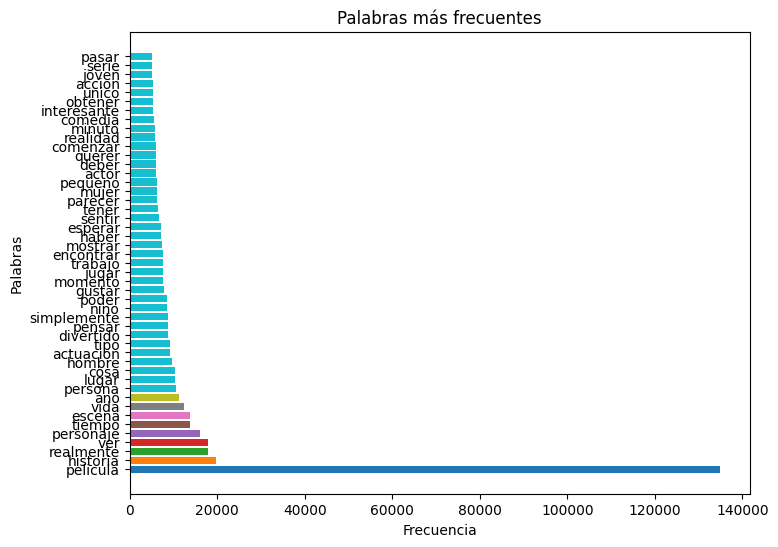

In [57]:
top_words = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)[:47]
words, frequencies = zip(*top_words)

colors = plt.cm.tab10(np.arange(len(words)))

plt.figure(figsize=(8, 6))
plt.barh(np.arange(len(words)), frequencies, color=colors)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras más frecuentes')

plt.show()

Observamos que algunas palabras pueden tener una carga sentimental, como por ejemplo divertido

Veamos el mismo gráfico con un umbral maximo más alto (10000)



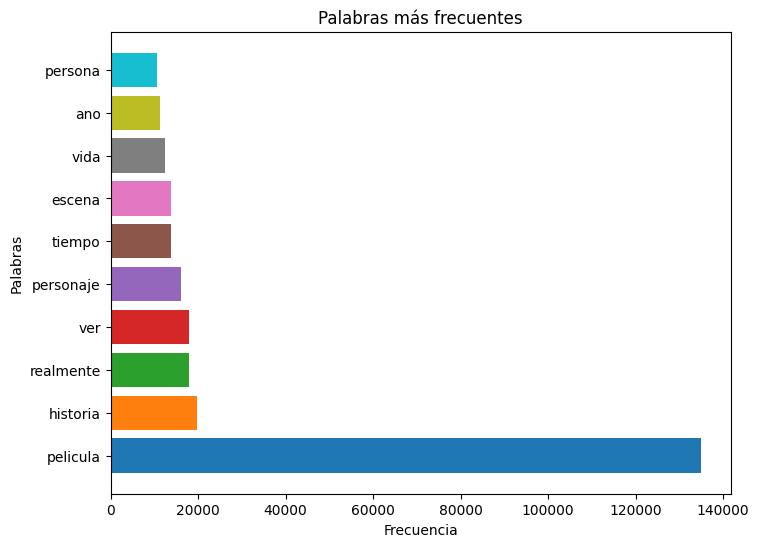

In [58]:
top_words = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]

words, frequencies = zip(*top_words)

colors = plt.cm.tab10(np.arange(len(words)))

plt.figure(figsize=(8, 6))
plt.barh(np.arange(len(words)), frequencies, color=colors)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras más frecuentes')

plt.show()

Observamos que tenemos palabras que son muy frecuentes en nuestro corpus por el contexto de nuestros datos, pero que no son muy relevantes para clasificar sentimientos. Por esta razon decidimos eliminar las palabras que tengan una frecuencia mayor a 10000

In [59]:
tokens_to_remove = [token for token, frequency in token_frequencies.items() if frequency > 10000]

train_data['tokens'] = train_data['tokens'].apply(lambda tokens_list: [token for token in tokens_list if token not in tokens_to_remove])

Observamos los tokens con una logitud baja. Filtramos por logitud menor a 4 ya que consideramos que son palabras irrelevantes

In [60]:
tokens_cant_letras = []

for lista_tokens in train_data['tokens']:
    for token in lista_tokens:
        if len(token) < 4:
            tokens_cant_letras.append(token)
token_frequencies = Counter(tokens_cant_letras)
print("Cantidad de tokens diferentes longitud menor a 4",len(token_frequencies))
print("Tokens difentes con su frecuencia: ",token_frequencies)

Cantidad de tokens diferentes longitud menor a 4 336
Tokens difentes con su frecuencia:  Counter({'dvd': 3903, 'ojo': 2721, 'voz': 2328, 'dar': 2126, 'rol': 2072, 'etc': 2046, 'ir': 1363, 'luz': 1288, 'ser': 962, 'tv': 949, 'rey': 714, 'mes': 645, 'vi': 590, 'oro': 521, 'pie': 508, 'feo': 484, 'cgi': 432, 'co': 425, 'bit': 407, 'tio': 401, 'lio': 393, 'rio': 369, 'vs': 336, 'oer': 334, 'gag': 328, 'mil': 279, 'rei': 278, 'paz': 263, 'ira': 252, 'pre': 250, 'ola': 243, 'xx': 226, 'vea': 187, 'tia': 182, 'mir': 181, 'art': 178, 'pez': 178, 'duo': 167, 'ves': 166, 'ok': 165, 'te': 165, 'oso': 165, 'cd': 159, 'oir': 153, 'ama': 153, 'com': 152, 'una': 150, 'dej': 147, 'xix': 140, 'fin': 139, 'mm': 139, 'pg': 121, 'eco': 117, 'gay': 116, 'cg': 111, 'ii': 102, 'red': 96, 'cao': 96, 'xxi': 93, 'ley': 92, 'dio': 89, 'fan': 85, 'ave': 83, 'vil': 80, 'lol': 78, 'eje': 77, 'bla': 77, 'et': 75, 'pm': 75, 'set': 73, 'via': 70, 'haz': 65, 'bar': 62, 'par': 59, 'rar': 57, 'iq': 55, 'sed': 54, 'ups': 

Eliminamos los tokens con longitud menor a 4, ya que consideramos que son palabras irrelevantes

In [61]:
longitud_deseada = 4
train_data['tokens'] = train_data['tokens'].apply(lambda tokens: [token for token in tokens if len(token) >= longitud_deseada])

Veamos el siguiente scatter text que permiten identificar y resaltar las palabras o que son más frecuentes o distintivas en una categoría en comparación con otras

In [62]:
corpus = st.CorpusFromPandas(train_data,
                             category_col='sentimiento',
                             text_col='review_es',
                             nlp=st.whitespace_nlp_with_sentences).build()

html = st.produce_scattertext_explorer(corpus,
                                       category='positivo',
                                       category_name='Sentimiento positivo',
                                       not_category_name='Sentimiento negativo',
                                       width_in_pixels=1000,
                                       metadata=corpus.get_df()['tokens'])

file_name = 'scattertext_visualization.html'
open(file_name, 'wb').write(html.encode('utf-8'))

display(HTML(html))

*   El grupo rojo representa las palabras utilizadas en la mayoría de los sentimientos positivos

*   El grupo azul representa las palabras que aparecen mayormente en los sentimientos negativos

*   El grupo con amarillo representa las palabras neutrales

*   Las palabras en el extremo derecho aparecen con mayor frecuencia en las reseñas que las del extremo izquierdo


Tomamos la decisión de cambiar positivo y negativo por 0 y 1, ya que algunos modelos lo necesitan, y así podemos trabajar siempre con estos datos

In [63]:
train_data['sentimiento'] = train_data['sentimiento'].map({'positivo': 1, 'negativo': 0})

Repetimos el proceso para los datos de test

### Replicamos preprocesamiento para test

A continuación tratamos al train_data de la misma manera que a test_data

In [ ]:
all_tokens_test = [token for review_tokens in test_data['tokens'] for token in review_tokens]
token_frequencies_test = Counter(all_tokens_test)

In [ ]:
print("Cantidad total de tokens: ",len(all_tokens_test))
print("Cantidad de tokens diferentes:",len(token_frequencies_test))

In [ ]:
frequencies = token_frequencies_test.values()
sorted_frequencies = sorted(frequencies, reverse=True)

x = list(range(1, len(sorted_frequencies) + 1))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, sorted_frequencies, linestyle='-')
ax.set_yscale('log')

plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de los Tokens')

ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

In [ ]:
word_counts = Counter(word for tokens in test_data['tokens'] for word in tokens)
frequent_words = [word for word, count in word_counts.items() if count < 4]
print("Cantidad de tokens diferentes: ",len(word_counts))
print("Cantidad de tokens con frecuencia menor al  umbral: ",len(frequent_words))

In [ ]:
tokens_cant_letras = []

for lista_tokens in test_data['tokens']:
    for token in lista_tokens:
        if len(token) < 4:
            tokens_cant_letras.append(token)
token_frequencies = Counter(tokens_cant_letras)
print("Cantidad de tokens diferentes longitud menor a 4",len(token_frequencies))
print("Tokens difentes con su frecuencia: ",token_frequencies)

In [ ]:
longitud_deseada = 4
test_data['tokens'] = test_data['tokens'].apply(lambda tokens: [token for token in tokens if len(token) >= longitud_deseada])

In [ ]:
frequency_threshold = 5
infrequent_tokens_test = [token for token, frequency in token_frequencies.items() if frequency < frequency_threshold]

test_data['tokens'] = test_data['tokens'].apply(lambda tokens: [token for token in tokens if token not in infrequent_tokens_test and token not in infrequent_tokens])
print("Cantidad de casos eliminados: ", len(frequent_words))

Tomamos la decisión de eliminar los tokens de test que se encuentran en la lista de frecuentes de train, ya que sabemos que estos tokens no aportan información y que pueden ser frecuentes en el contexto de nuestro set de datos

In [ ]:
test_data['tokens'] = test_data['tokens'].apply(lambda tokens_list: [token for token in tokens_list if token not in tokens_to_remove])

####Eliminar la columna 'review_es' del dataframe

Decidimos eliminar la colimna con todas las reviews, ya que no son utilizadas por nuestros modelos

In [ ]:
train_data = train_data.drop('review_es', axis=1)
test_data = test_data.drop('review_es', axis=1)

Descargamos ambos set de datos para utilizar luego en nuestros modelos

In [ ]:
test_data.to_csv('test_data_procesado_FILTRADO_FINAL.csv', index=False)

num_rows = train_data.shape[0]
num_partes = 2
tamano_parte = num_rows/num_partes

for i in range(num_partes):
    inicio = int(i * tamano_parte)
    fin = int(inicio + tamano_parte)
    print(f'{i}=> Inicio: {inicio}, Fin: {fin}')

    parte = train_data.iloc[inicio:fin]
    parte.to_csv(f'train_data_procesado_FILTRADO_FINAL_parte_{i}.csv', index=False)
